## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Насыбуллин А. А.|
|---------|--------|
| Группа  | М8О-107М-20 VR/AR & ИИ|

Для скачивания датасетов можно Использовать `wget` или `curl`, либо скачать вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

### Подключение модулей и библиотек

In [2]:
import pickle
import numpy as np
import os

In [3]:
import shutil
shutil.rmtree('img_mnist')

Получение модуля `mlp.py`, в котором содержатся неободимые для работы классы нейронной сети

In [4]:
!wget -P . 'https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/NotebooksColab/MLP/mlp.py'

--2021-06-15 08:14:05--  https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/NotebooksColab/MLP/mlp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11112 (11K) [text/plain]
Saving to: ‘./mlp.py’

mlp.py              100%[===================>]  10.85K  --.-KB/s    in 0s      

2021-06-15 08:14:05 (88.4 MB/s) - ‘./mlp.py’ saved [11112/11112]



Подключение модуля `mlp` для дальнейшего использования

In [5]:
import mlp

### Установка модулей для загрузки и распаковки данных

In [6]:
!pip install gzip-reader
!pip install rm
!pip install wget

## MNIST

### Настройка путей для сохранения файлов

In [8]:
if 'google.colab' in str(get_ipython()):
  data_dir = os.path.join(os.getcwd(), '/content/data/mnist')
else:
  data_dir = os.path.join(os.getcwd(), '../../../data/mnist')


img_dir = os.path.join(os.getcwd(), 'img_mnist')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

### MNIST. Загрузка данных

Скачивание данных с помощью инстрмента curl и разархивация данных с помощью инструмента gzip

In [9]:
if 'google.colab' in str(get_ipython()):
  !rm -r /content/data/mnist
  !wget -P data/mnist https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
  !gzip -d /content/data/mnist/mnist.pkl.gz
else:
  !gzip -d ../data/mnist/mnist.pkl.gz

--2021-06-15 08:15:03--  https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10392609 (9.9M) [application/octet-stream]
Saving to: ‘data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]   9.91M  38.3MB/s    in 0.3s    

2021-06-15 08:15:03 (38.3 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [10392609/10392609]



### MNIST. Чтение и просмотр данных

In [10]:
with open(os.path.join(data_dir, 'mnist.pkl'), 'rb') as f:
    MNIST = pickle.load(f)

MNIST

{'Train': {'Features': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
  'Labels': array([1, 0, 1, ..., 7, 6, 9], dtype=int32)}}

Видно, что имеется 2 набора данных:
- Features - матрица признаковых описаний объектов (значения пикселей каждой картинки)
- Labels - вектор ответов (принадлежность картинки к определенному классу)

Разделим данные на 2 переменные:
- labels - вектор ответов (значения классов)
- data - матрица признаков (значения пикселей)

In [11]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

### MNIST. Первоначальный анализ данных, предобработка

Выведем основную информацию:
- количество признаков (пикселей)
- количество объектов (картинок)
- количество разных ответов (классов)

In [12]:
print(f'Количество признаков (пикселей): {data.shape[1]}')
print(f'Количество объектов (картинок): {data.shape[0]}')
print(f'Количество разных ответов (классов): {len(np.unique(labels))}')

Количество признаков (пикселей): 784
Количество объектов (картинок): 42000
Количество разных ответов (классов): 10


Необходимо:
1. Поменять тип данных для признаков на float, чтобы во время обучения и применения нейронных сетей тип данных был везде одинаковый. При приведении к int дробная часть отсекается, что ведет к увеличению погрешности в вычислениях
2. Отмасштабировать все значения пикселей к значениям от 0 до 1,иначе в ходе вычислений большие значения могут привести к ошибкам

In [13]:
data = data.astype(float)
data = data / 255

Разбиваем признаки и ответы на обучающую и тестовую выборки в соотношении 70/30

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

### MNIST. Применение нейронных сетей и отображение графика обучения

In [15]:
loss = mlp.LossFunction('cross-entropy')
metrics = mlp.NeuralNetworkMetrics()
n_epoch = 30

Применение нейронной сети с одним слоем (с различными гиперпараметрами)

Initial train loss=2.354, accuracy=0.136
Initial valid loss=2.354, accuracy=0.135
Final train loss=0.286, accuracy=0.921
Final valid loss=0.308, accuracy=0.914


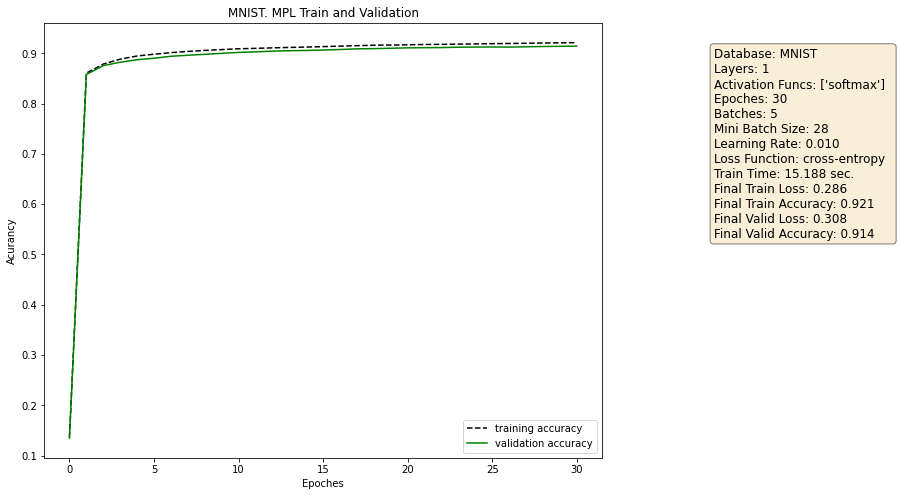

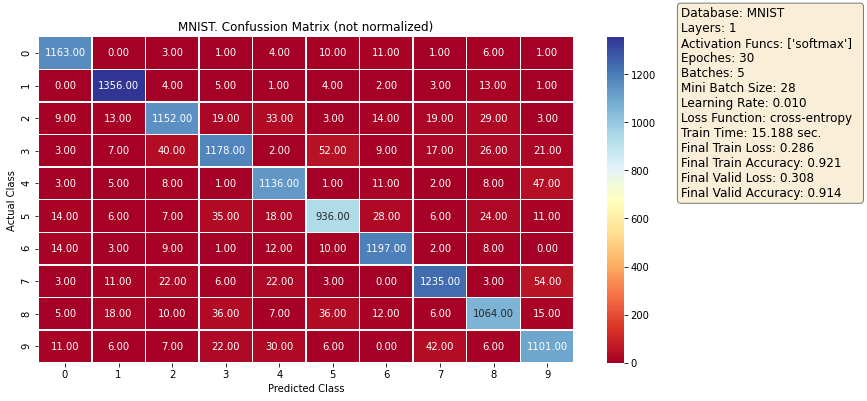

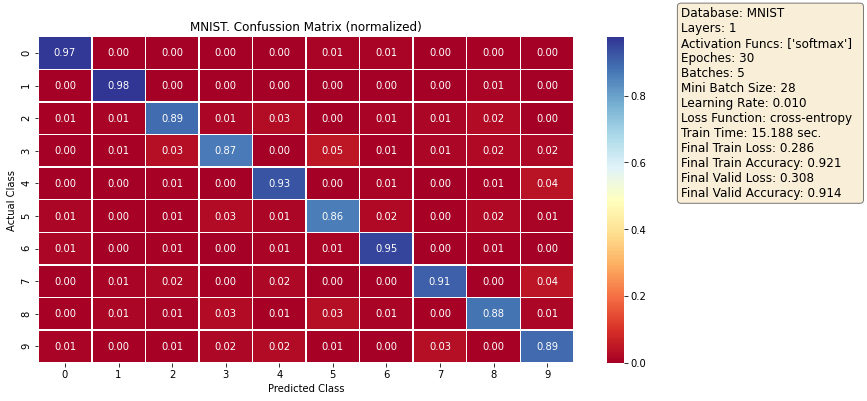

Database: MNIST  
Layers: 1  
Activation Funcs: ['softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.010  
Loss Function: cross-entropy  
Train Time: 15.188 sec.  
Final Train Loss: 0.286  
Final Train Accuracy: 0.921  
Final Valid Loss: 0.308  
Final Valid Accuracy: 0.914


In [16]:
layer1 = mlp.NeuralNetworkLayer(784, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 1'), img_format=' 1.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 1'), ' 1.png', description)
print(description)

Initial train loss=2.382, accuracy=0.143
Initial valid loss=2.381, accuracy=0.148
Final train loss=0.243, accuracy=0.932
Final valid loss=0.287, accuracy=0.920


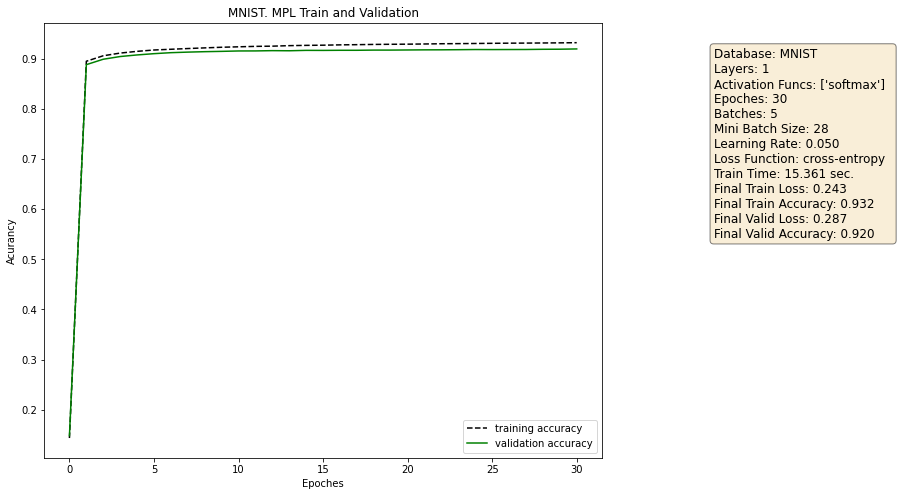

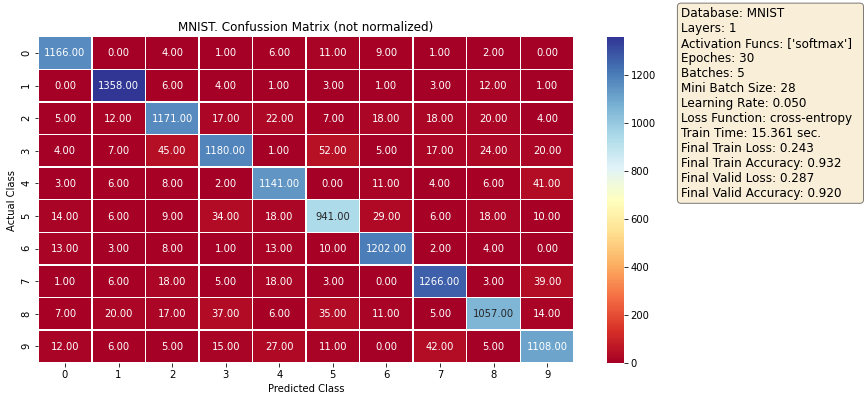

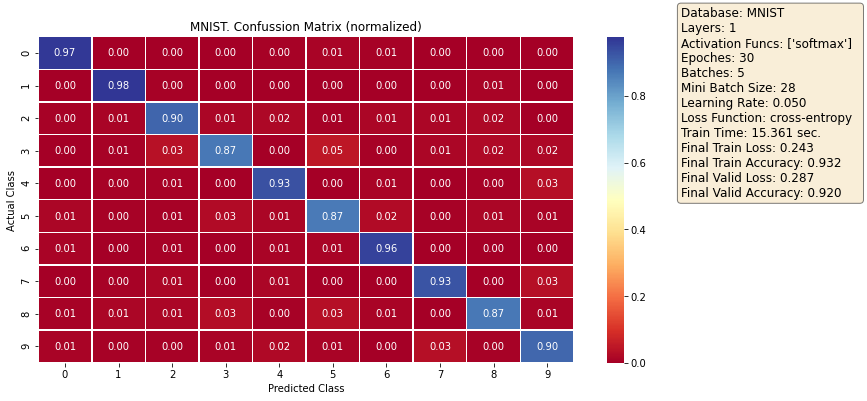

Database: MNIST  
Layers: 1  
Activation Funcs: ['softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.050  
Loss Function: cross-entropy  
Train Time: 15.361 sec.  
Final Train Loss: 0.243  
Final Train Accuracy: 0.932  
Final Valid Loss: 0.287  
Final Valid Accuracy: 0.920


In [17]:
layer1 = mlp.NeuralNetworkLayer(784, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.05)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 1'), img_format=' 2.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 1'), ' 2.png', description)
print(description)

Initial train loss=2.349, accuracy=0.098
Initial valid loss=2.344, accuracy=0.102
Final train loss=0.232, accuracy=0.936
Final valid loss=0.290, accuracy=0.919


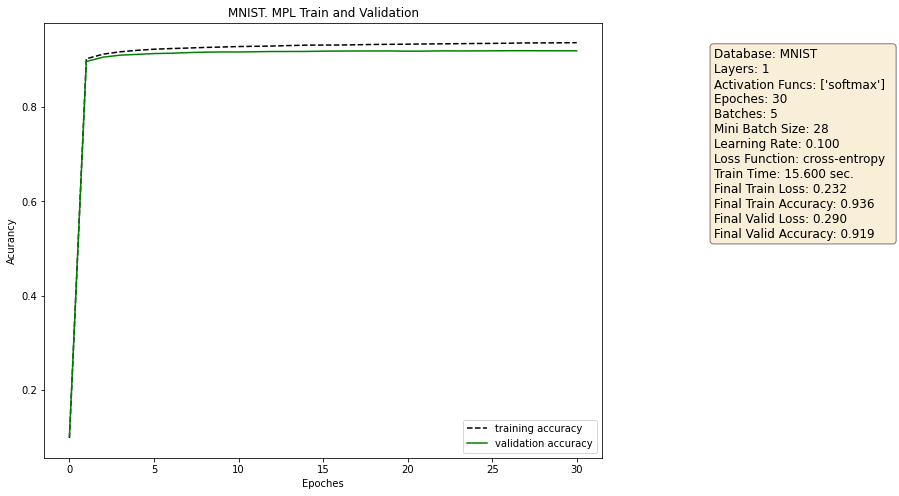

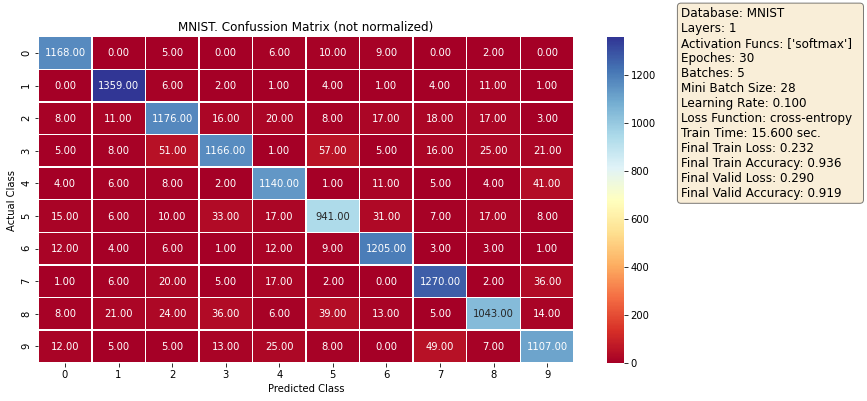

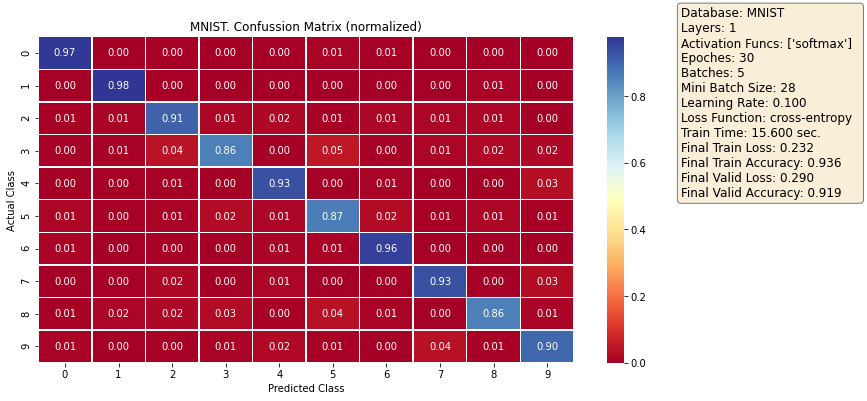

Database: MNIST  
Layers: 1  
Activation Funcs: ['softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.100  
Loss Function: cross-entropy  
Train Time: 15.600 sec.  
Final Train Loss: 0.232  
Final Train Accuracy: 0.936  
Final Valid Loss: 0.290  
Final Valid Accuracy: 0.919


In [18]:
layer1 = mlp.NeuralNetworkLayer(784, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.1)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 1'), img_format=' 3.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 1'), ' 3.png', description)
print(description)

### Применение нейронной сети с 2-мя слоями (с различными гиперпараметрами)

Initial train loss=2.298, accuracy=0.142
Initial valid loss=2.295, accuracy=0.146
Final train loss=0.157, accuracy=0.957
Final valid loss=0.194, accuracy=0.944


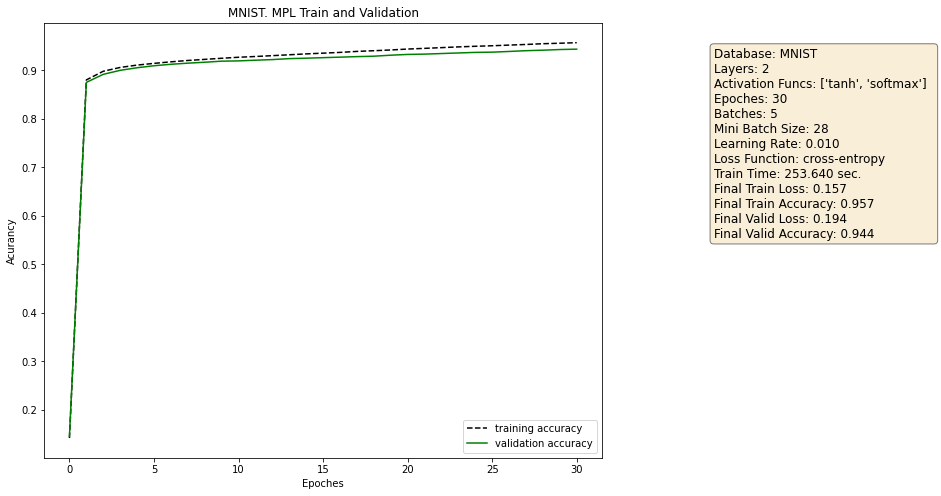

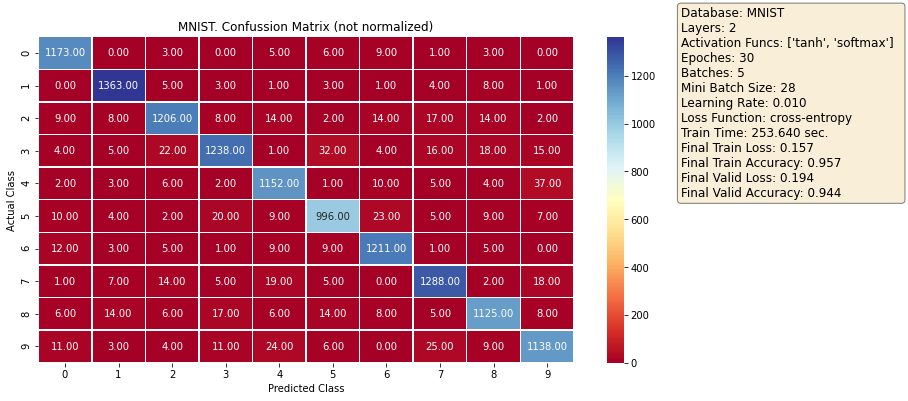

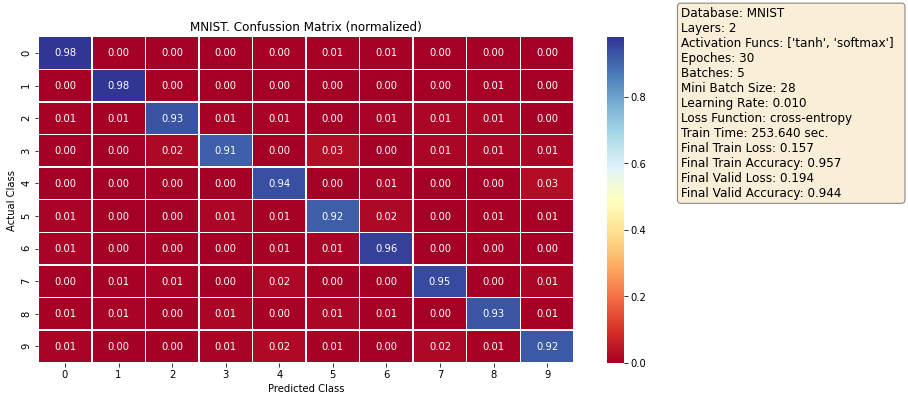

Database: MNIST  
Layers: 2  
Activation Funcs: ['tanh', 'softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.010  
Loss Function: cross-entropy  
Train Time: 253.640 sec.  
Final Train Loss: 0.157  
Final Train Accuracy: 0.957  
Final Valid Loss: 0.194  
Final Valid Accuracy: 0.944


In [19]:
layer1 = mlp.NeuralNetworkLayer(784, 392, activation_func=mlp.ActivationFunction('tanh'))
layer2 = mlp.NeuralNetworkLayer(392, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1, layer2])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 2'), img_format=' 1.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 2'), ' 1.png', description)
print(description)

Initial train loss=2.382, accuracy=0.092
Initial valid loss=2.379, accuracy=0.088
Final train loss=0.284, accuracy=0.918
Final valid loss=0.303, accuracy=0.912


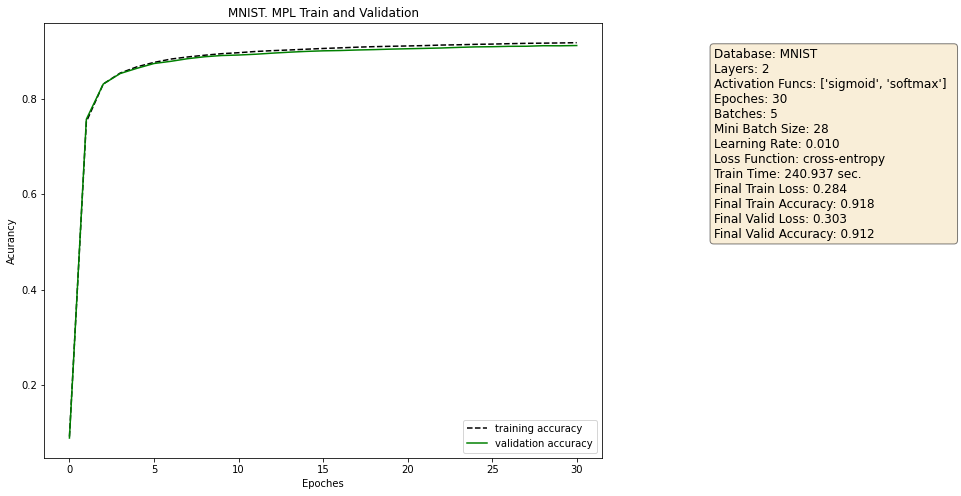

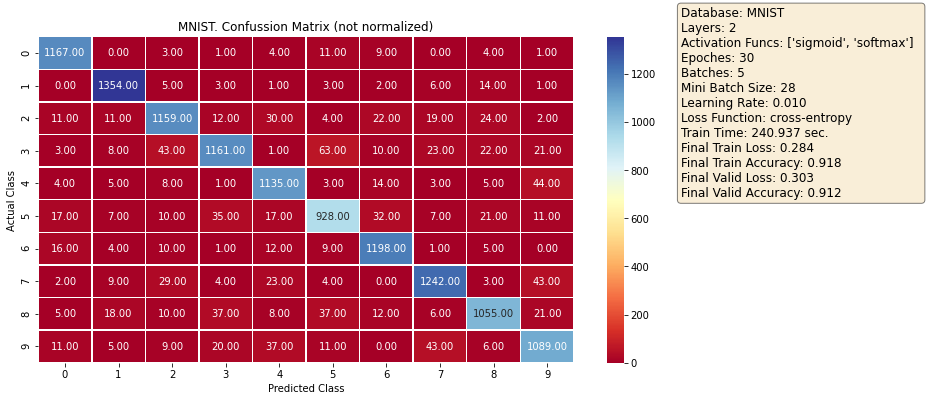

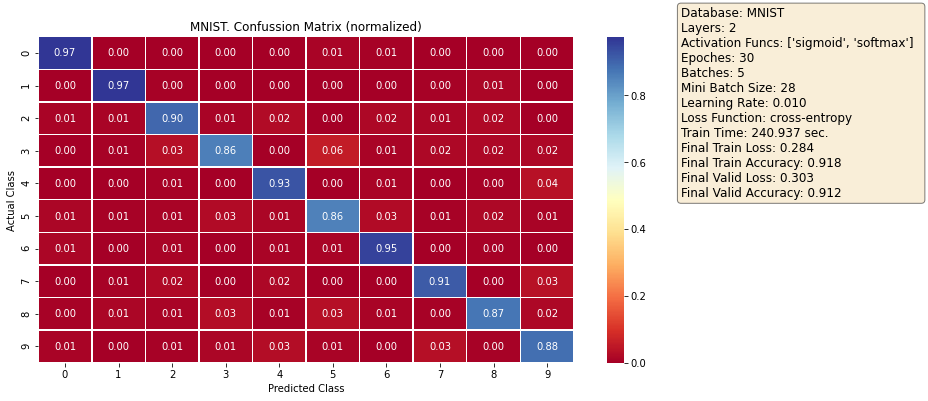

Database: MNIST  
Layers: 2  
Activation Funcs: ['sigmoid', 'softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.010  
Loss Function: cross-entropy  
Train Time: 240.937 sec.  
Final Train Loss: 0.284  
Final Train Accuracy: 0.918  
Final Valid Loss: 0.303  
Final Valid Accuracy: 0.912


In [20]:
layer1 = mlp.NeuralNetworkLayer(784, 392, activation_func=mlp.ActivationFunction('sigmoid'))
layer2 = mlp.NeuralNetworkLayer(392, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1, layer2])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 2'), img_format=' 2.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 2'), ' 2.png', description)
print(description)

### Применение нейронной сети с 3-мя слоями (с различными гиперпараметрами)

Initial train loss=2.368, accuracy=0.118
Initial valid loss=2.372, accuracy=0.117
Final train loss=0.192, accuracy=0.945
Final valid loss=0.221, accuracy=0.935


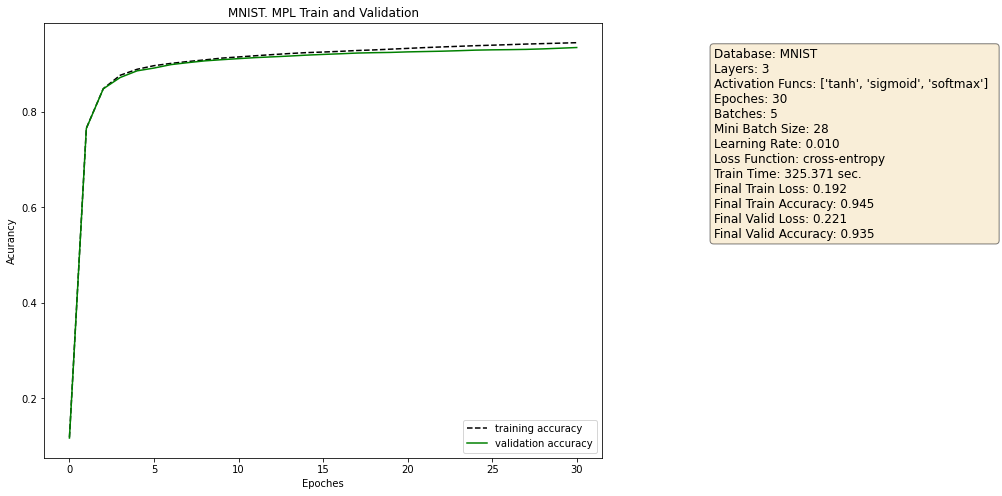

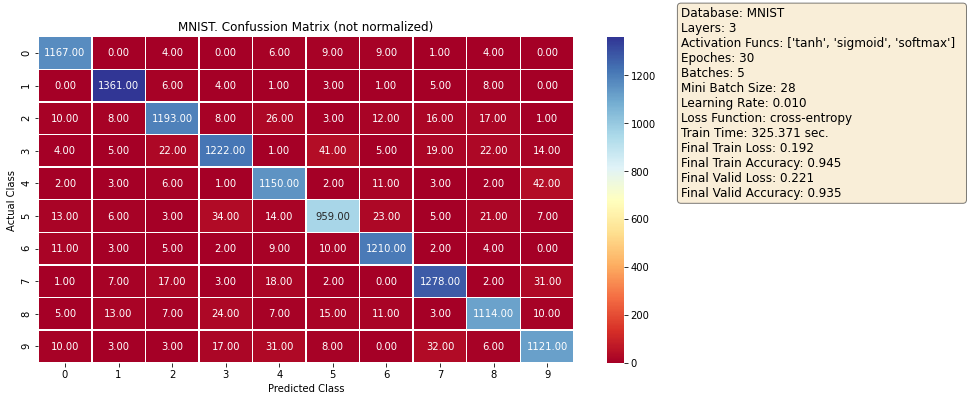

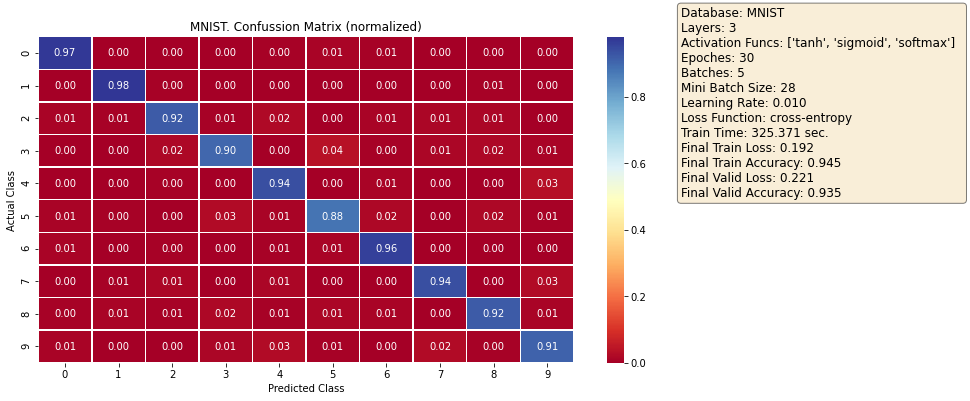

Database: MNIST  
Layers: 3  
Activation Funcs: ['tanh', 'sigmoid', 'softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.010  
Loss Function: cross-entropy  
Train Time: 325.371 sec.  
Final Train Loss: 0.192  
Final Train Accuracy: 0.945  
Final Valid Loss: 0.221  
Final Valid Accuracy: 0.935


In [21]:
layer1 = mlp.NeuralNetworkLayer(784, 392, activation_func=mlp.ActivationFunction('tanh'))
layer2 = mlp.NeuralNetworkLayer(392, 196, activation_func=mlp.ActivationFunction('sigmoid'))
layer3 = mlp.NeuralNetworkLayer(196, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1, layer2, layer3])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 3'), img_format=' 1.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 3'), ' 1.png', description)
print(description)

Initial train loss=2.395, accuracy=0.098
Initial valid loss=2.395, accuracy=0.100
Final train loss=0.231, accuracy=0.932
Final valid loss=0.260, accuracy=0.923


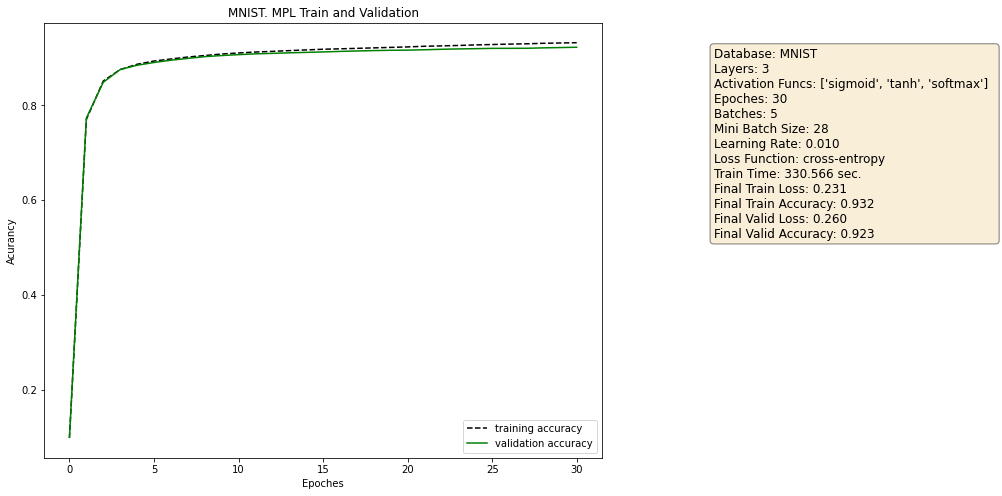

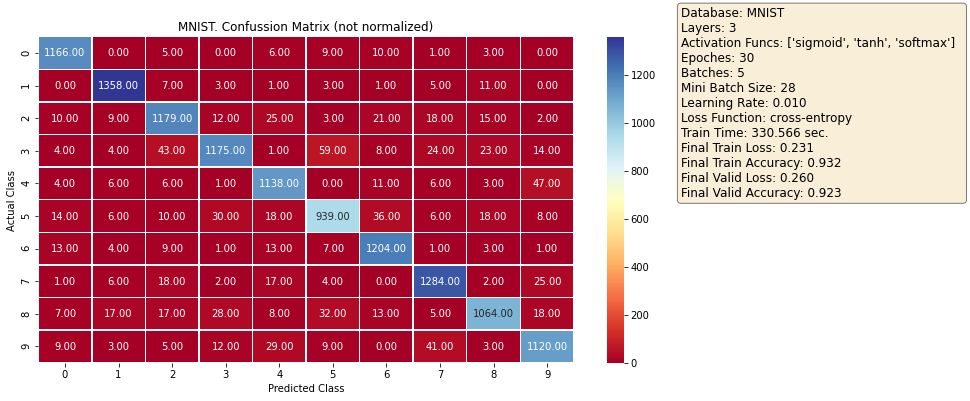

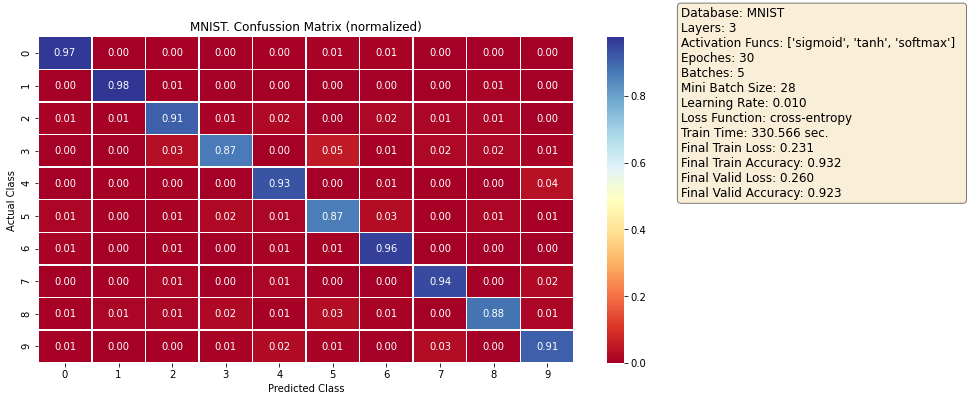

Database: MNIST  
Layers: 3  
Activation Funcs: ['sigmoid', 'tanh', 'softmax']  
Epoches: 30  
Batches: 5  
Mini Batch Size: 28  
Learning Rate: 0.010  
Loss Function: cross-entropy  
Train Time: 330.566 sec.  
Final Train Loss: 0.231  
Final Train Accuracy: 0.932  
Final Valid Loss: 0.260  
Final Valid Accuracy: 0.923


In [22]:
layer1 = mlp.NeuralNetworkLayer(784, 392, activation_func=mlp.ActivationFunction('sigmoid'))
layer2 = mlp.NeuralNetworkLayer(392, 196, activation_func=mlp.ActivationFunction('tanh'))
layer3 = mlp.NeuralNetworkLayer(196, 10, activation_func=mlp.ActivationFunction('softmax'))
net = mlp.NeuralNetwork([layer1, layer2, layer3])
trainer = mlp.NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = mlp.train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='MNIST', img_dir=os.path.join(img_dir, 'layers 3'), img_format=' 2.png')
mlp.plot_confusion_matrix(net, x_test, y_test, loss, 5, metrics, 'MNIST', os.path.join(img_dir, 'layers 3'), ' 2.png', description)
print(description)

In [23]:
# архивирование папки с графиками
# !zip -r /content/img_mnist.zip /content/img_mnist

  adding: content/img_mnist/ (stored 0%)
  adding: content/img_mnist/layers 3/ (stored 0%)
  adding: content/img_mnist/layers 3/MNIST. Confussion Matrix (not normalized) 2.png (deflated 4%)
  adding: content/img_mnist/layers 3/MNIST. MPL Train and Validation 2.png (deflated 7%)
  adding: content/img_mnist/layers 3/MNIST. Confussion Matrix (normalized) 2.png (deflated 5%)
  adding: content/img_mnist/layers 3/MNIST. MPL Train and Validation 1.png (deflated 7%)
  adding: content/img_mnist/layers 3/MNIST. Confussion Matrix (not normalized) 1.png (deflated 4%)
  adding: content/img_mnist/layers 3/MNIST. Confussion Matrix (normalized) 1.png (deflated 5%)
  adding: content/img_mnist/layers 2/ (stored 0%)
  adding: content/img_mnist/layers 2/MNIST. Confussion Matrix (not normalized) 2.png (deflated 4%)
  adding: content/img_mnist/layers 2/MNIST. MPL Train and Validation 2.png (deflated 7%)
  adding: content/img_mnist/layers 2/MNIST. Confussion Matrix (normalized) 2.png (deflated 4%)
  adding: 

In [24]:
# скачивание архива себе на ПК
# from google.colab import files
# files.download("/content/img_mnist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Результаты моделей нейронных сетей с различными параметрами при работе с набором данных **MNIST**

|Layers|Activation Functions|Loss Function|Epoches/Batches/Mini Batches Size|Learning Rate|Train Time|Final Train Loss|Final Train Accurancy|Final Valid Loss|Final Valid Accurancy|Best Class/Accurancy|Worst Class/Accurancy|
|---|---|---|---|---|---|---|---|---|---|---|---|
|1|softmax|cross-entropy|30/5/28|0.01|15.188 sec.|0.286|0.921|0.308|0.914|1 / 0.98 <br> 0 / 0.97 <br> 6 / 0.95|5 / 0.86 <br> 3 / 0.87 <br> 8 / 0.88|
|1|softmax|cross-entropy|30/5/28|0.05|15.361 sec.|0.243|0.932|0.287|0.920|1 / 0.98 <br> 0 / 0.97 <br> 6 / 0.96|3 / 0.87 <br> 5 / 0.87 <br> 8 / 0.87|
|1|softmax|cross-entropy|30/5/28|0.1|15.6 sec.|0.232|0.936|0.29|0.919|1 / 0.98 <br> 0 / 0.97 <br> 6 / 0.96|3 / 0.86 <br> 8 / 0.86 <br> 5 / 0.87|
|---|
|2|tanh/softmax|cross-entropy|30/5/28|0.01|253.64 sec.|0.157|0.957|0.194|0.944|0 / 0.98 <br> 1 / 0.98 <br> 6 / 0.96|3 / 0.91 <br> 5 / 0.92 <br> 9 / 0.92|
|2|sigmoid/softmax|cross-entropy|30/5/28|0.01|240.937 sec.|0.284|0.918|0.303|0.912|0 / 0.97 <br> 1 / 0.97 <br> 6 / 0.95|3 / 0.86 <br> 5 / 0.86 <br> 8 / 0.87|
|---|
|3|tanh/sigmoid/softmax|cross-entropy|30/5/28|0.01|325.371 sec.|0.192|0.945|0.221|0.935|1 / 0.98 <br> 0 / 0.97 <br> 6 / 0.96|5 / 0.88 <br> 3 / 0.90 <br> 9 / 0.91|
|3|sigmoid/tanh/softmax|cross-entropy|30/5/28|0.01|330.566 sec.|0.231|0.923|0.260|0.923|1 / 0.98 <br> 0 / 0.97 <br> 6 / 0.96|3 / 0.87 <br> 5 / 0.87 <br> 8 / 0.88|

## Вывод
1. На наборе данных простейшая нейронная сеть на основе персептронов способна распознать изображения с довольно высокой точностью (> 0.90).
2. При увеличении количества слоев нейронной сети, продолжительность работы возрастает.
3. Наибольшую точность распознавания получили классы изображений: **0, 1, 6**.
4. Наименее точно распознавались изображения из классов: **3, 5, 8**
